In [ ]:
import os
import shutil

import matplotlib as plt

from dummy_baskets import generate_dummy_baskets, run_index_basket_upload_test
from weave.index.index_pandas import IndexPandas
from weave.index.index_sqlite import IndexSQLite


**Pandas Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type)**

In these tests we will be analyzing the performance differences when more files are uploaded, files are larger, and the number of basket types are increased. This will done using the pandas index.

In [2]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
pandas_time1 = run_index_basket_upload_test(basket_list=baskets, index=IndexPandas, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type: {pandas_time1} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

Time taken to upload 1000 baskets: 173.3378701210022 seconds.
1000 baskets, 1 upload file, 1 mb size files, 1 basket type: 173.3378701210022 seconds


In [3]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
pandas_time2 = run_index_basket_upload_test(basket_list=baskets, index=IndexPandas, pantry_path="dummy_pantry")
print(f"1000 baskets, 10 upload files, 1 mb size files, 1 basket type: {pandas_time2} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

Time taken to upload 1000 baskets: 171.4100148677826 seconds.
1000 baskets, 10 upload files, 1 mb size files, 1 basket type: 171.4100148677826 seconds


Performance difference between uploading 10 files in each basket compared to 1 file in each basket

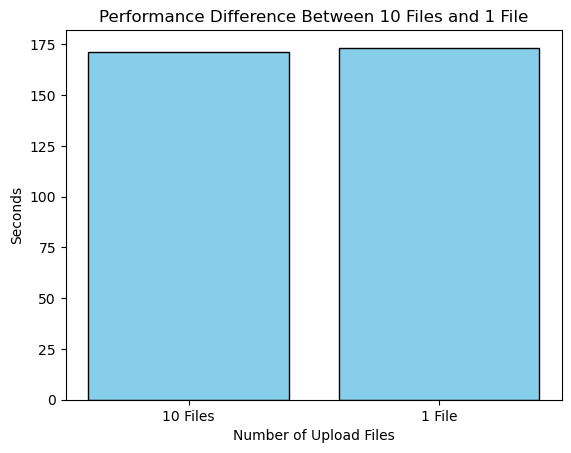

In [4]:
categories = ["10 Files", "1 File"]
values = [pandas_time2, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Number of Upload Files')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 10 Files and 1 File')

plt.show()


As you can see there is almost no difference in performance when we upload multiple files in each basket compared to one file

In [5]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=2, file_path="dummy_txt", num_basket_types=1)
pandas_time3 = run_index_basket_upload_test(basket_list=baskets, index=IndexPandas, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 2 mb size files, 1 basket type: {pandas_time3} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

Time taken to upload 1000 baskets: 162.24330639839172 seconds.
1000 baskets, 1 upload file, 2 mb size files, 1 basket type: 162.24330639839172 seconds


Performance difference between uploading a 2 mb file in each basket compared to a 1 mb file in each basket

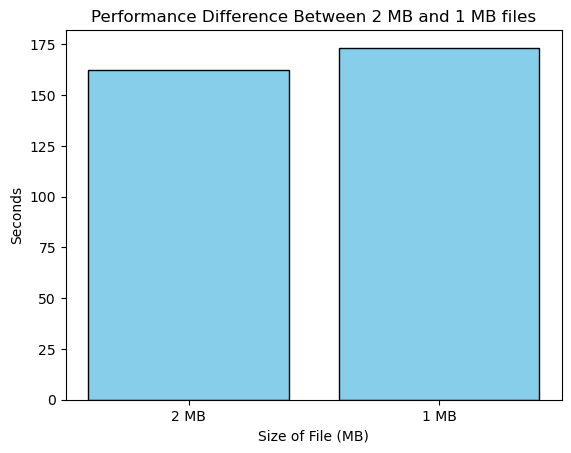

In [6]:
categories = ["2 MB", "1 MB"]
values = [pandas_time3, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Size of File (MB)')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 2 MB and 1 MB files')

plt.show()

Once again, there is almost no performance difference between uploading a 2 MB file and a 1 MB file in each basket

In [7]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=10)
pandas_time4 = run_index_basket_upload_test(basket_list=baskets, index=IndexPandas, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 1 mb size files, 10 basket types: {pandas_time4} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

Time taken to upload 1000 baskets: 161.98333621025085 seconds.
1000 baskets, 1 upload file, 1 mb size files, 10 basket types: 161.98333621025085 seconds


Performance difference between uploading 10 basket types versus 1 basket types

Text(0.5, 1.0, 'Performance Difference Between 10 and 1 Basket Types')

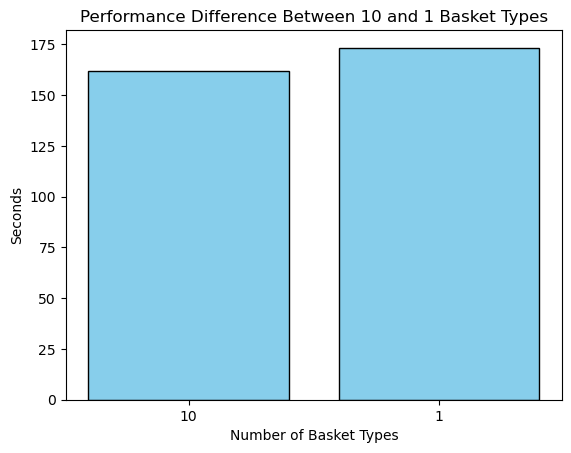

In [8]:
categories = ["10", "1"]
values = [pandas_time4, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Number of Basket Types')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 10 and 1 Basket Types')

Once again, there seems to be no performance difference between number of basket types

**SQLite Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type)**

In this test we will test the performance of uploading baskets using the same parameters as the first index pandas test. We will be using the SQLite index backend for these tests.

In [11]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
sqlite_time1 = run_index_basket_upload_test(basket_list=baskets, index=IndexSQLite, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type: {sqlite_time1} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")
os.remove("dummy_pantry.db")


Time taken to upload 1000 baskets: 34.46479344367981 seconds.
1000 baskets, 1 upload file, 1 mb size files, 1 basket type: 34.46479344367981 seconds


Performance difference between the Pandas Index and the SQLite index

Text(0.5, 1.0, 'Performance Difference Between Pandas and SQLite Indexes')

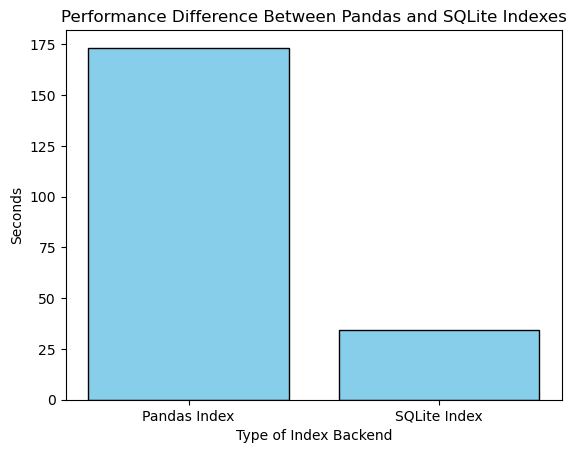

In [12]:
categories = ["Pandas Index", "SQLite Index"]
values = [pandas_time1, sqlite_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Performance Difference Between Pandas and SQLite Indexes')

From the graph we can see there is a huge performance difference between the pandas and sqlite indexes